In [1]:
# ## 1. ASL with CNN
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(5)
tf.random.set_seed(2)

In [2]:
# ## 2. Loading the Data

train_dir = r"E:\asl_alphabet_train_processed\asl_alphabet_train_processed"
eval_dir = "E:/ASL_Alphabet_Dataset/asl_alphabet_test"

def load_images(directory, uniq_labels):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        label_path = os.path.join(directory, label)
        for file in os.listdir(label_path):
            filepath = os.path.join(label_path, file)
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    return np.array(images), np.array(labels)

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(train_dir, uniq_labels)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(eval_dir, uniq_labels)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:/ASL_Alphabet_Dataset/asl_alphabet_test'

In [ ]:
print(f"Training directory labels: {uniq_labels}")
print(f"Evaluation directory labels: {sorted(os.listdir(eval_dir))}")

In [ ]:
def load_images_with_jpg(directory, uniq_labels):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        label_with_ext = label + ".jpg"  # Append .jpg to the label
        label_path = os.path.join(directory, label_with_ext)
        if not os.path.exists(label_path):
            print(f"File missing: {label_path}")
            continue
        image = cv2.resize(cv2.imread(label_path), (64, 64))
        images.append(image)
        labels.append(idx)
    return np.array(images), np.array(labels)

# Add .jpg to unique labels for evaluation directory
uniq_labels_with_jpg = [label + ".jpg" for label in uniq_labels]

# Load evaluation images
X_eval, y_eval = load_images_with_jpg(eval_dir, uniq_labels)

print(f"Number of evaluation images loaded: {len(X_eval)}")


In [11]:
# ## 2.1 Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print(f"Total number of symbols: {n}")
print(f"Number of training images: {train_n}")
print(f"Number of testing images: {test_n}")

Total number of symbols: 28
Number of training images: 160518
Number of testing images: 17836


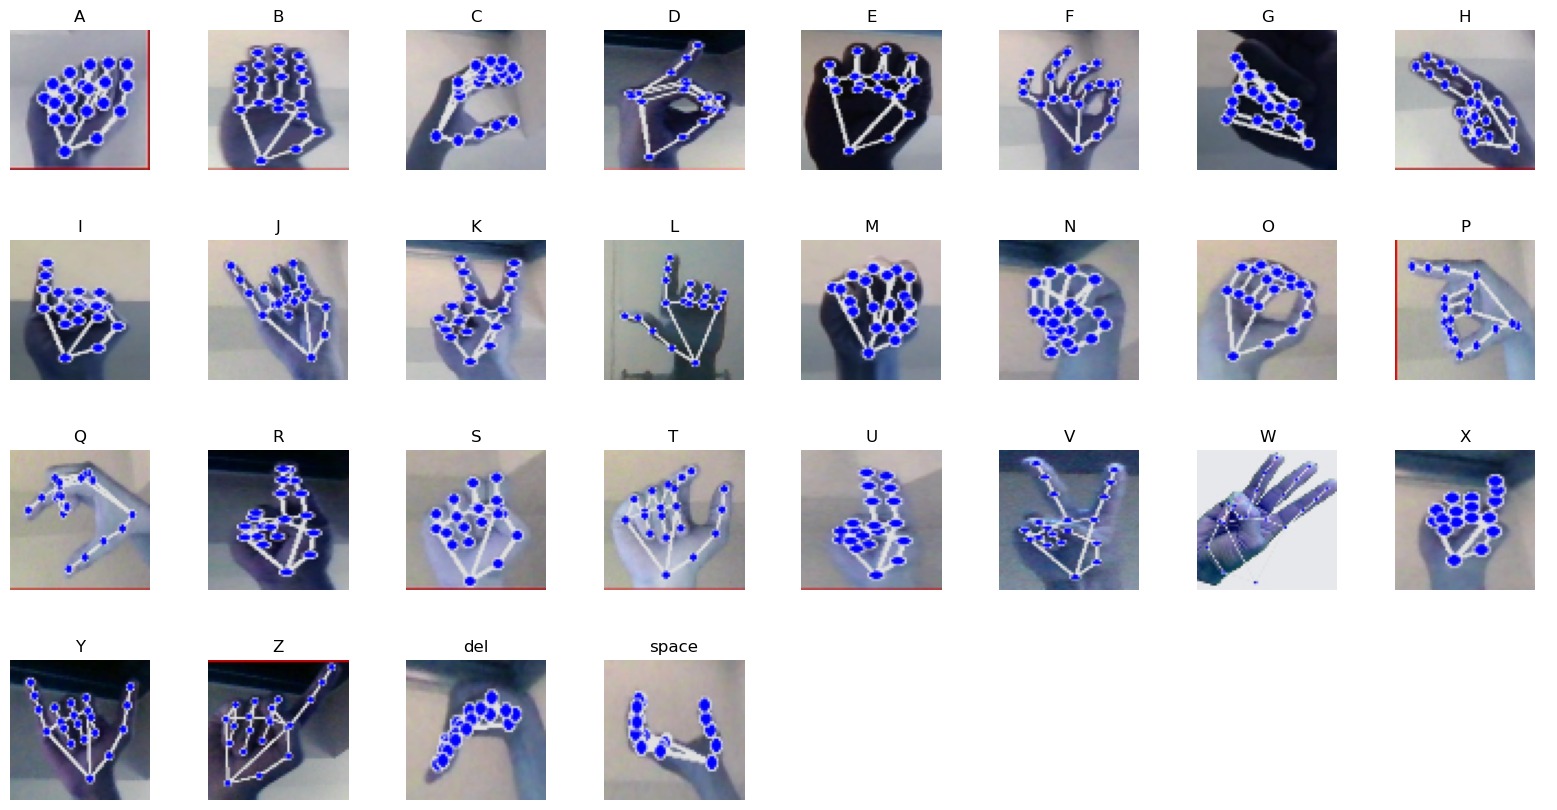

In [12]:
# Print one image for each label
def print_one_image_per_label(X, y, uniq_labels):
    label_indices = {}  # To store the index of the first occurrence of each label
    for i, label in enumerate(y):
        if label not in label_indices:  # Store the first occurrence only
            label_indices[label] = i
    
    # Set up the plot
    rows = (len(uniq_labels) + 7) // 8  # Number of rows for the subplot
    cols = 8
    fig, ax = plt.subplots(rows, cols, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5)
    
    for idx, label in enumerate(uniq_labels):
        row, col = divmod(idx, cols)
        if idx < len(label_indices):  # Only plot existing labels
            img_idx = label_indices[idx]
            ax[row, col].imshow(X[img_idx].astype('uint8'))
            ax[row, col].set_title(label)
        ax[row, col].axis('off')
    
    # Hide extra subplots if any
    for i in range(len(uniq_labels), rows * cols):
        row, col = divmod(i, cols)
        ax[row, col].axis('off')
    
    plt.show()

# Ensure labels are not one-hot encoded
if len(y_train.shape) > 1:
    y_train_labels = y_train.argmax(axis=1)
else:
    y_train_labels = y_train

# Call the function
print_one_image_per_label(X_train, y_train_labels, uniq_labels)


In [13]:
# ## 4. Preprocessing: One-Hot Encoding

y_train = to_categorical(y_train, num_classes=n)
y_test = to_categorical(y_test, num_classes=n)

print(f"Example one-hot encoded label: {y_train[0]}")

Example one-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [14]:
# ## 5. Normalizing RGB Values

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [15]:
# ## 6. Define and Run the Model

model = Sequential([
    Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(64, 64, 3)),
    Conv2D(64, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((4, 4)),
    Dropout(0.5),
    Conv2D(128, (5, 5), padding='same', activation='relu'),
    Conv2D(128, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((4, 4)),
    Dropout(0.5),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(n, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(monitor='loss', patience=2, cooldown=0),
    EarlyStopping(monitor='accuracy', patience=2, min_delta=1e-4)
]

hist = model.fit(X_train, y_train, epochs=10, batch_size=64, callbacks=callbacks)

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28)                  │         114,716 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,656,156 (6.32 MB)

 Trainable params: 1,656,156 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 361s 143ms/step - accuracy: 0.6801 - loss: 1.1367 - learning_rate: 0.0010
Epoch 2/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 360s 144ms/step - accuracy: 0.9400 - loss: 0.2133 - learning_rate: 0.0010
Epoch 3/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 362s 144ms/step - accuracy: 0.9519 - loss: 0.1752 - learning_rate: 0.0010
Epoch 4/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 361s 144ms/step - accuracy: 0.9567 - loss: 0.1584 - learning_rate: 0.0010
Epoch 5/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 361s 144ms/step - accuracy: 0.9580 - loss: 0.1546 - learning_rate: 0.0010
Epoch 6/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 361s 144ms/step - accuracy: 0.9601 - loss: 0.1472 - learning_rate: 0.0010
Epoch 7/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 361s 144ms/step - accuracy: 0.9609 - loss: 0.1477 - learning_rate: 0.0010
Epoch 8/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 360s 143ms/step - accuracy: 0.9609 - loss: 0.1495 - learning_rate: 0.0010
Epoch 9/10
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 360s 144ms/step - accuracy: 0.

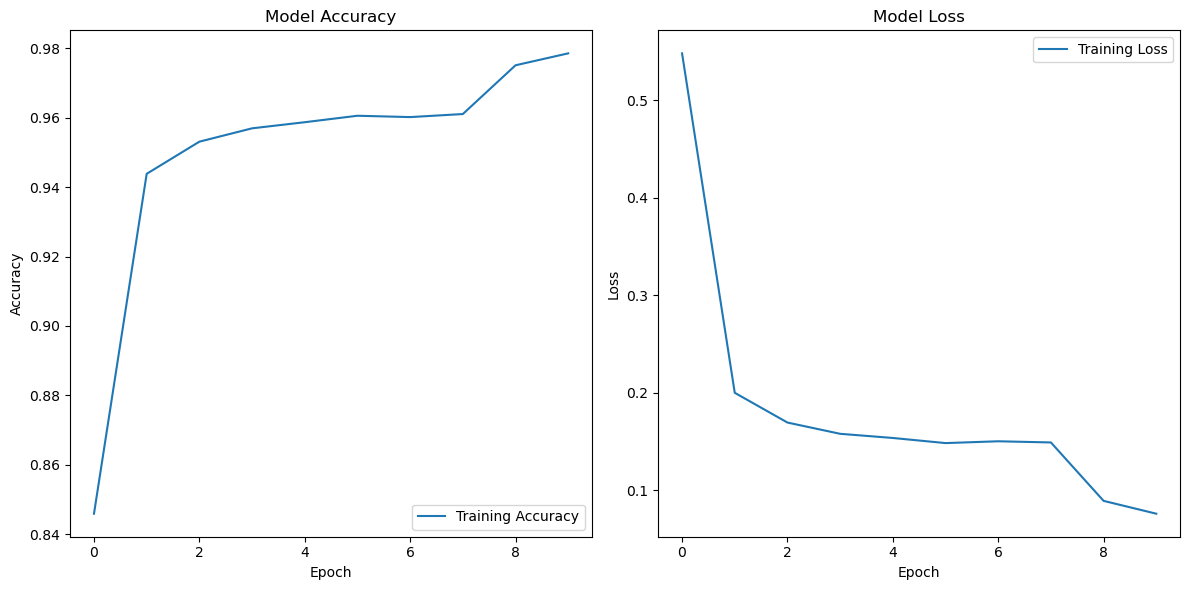

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in hist.history:
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
if 'val_loss' in hist.history:
    plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()


Accuracy for test images: 98.64%


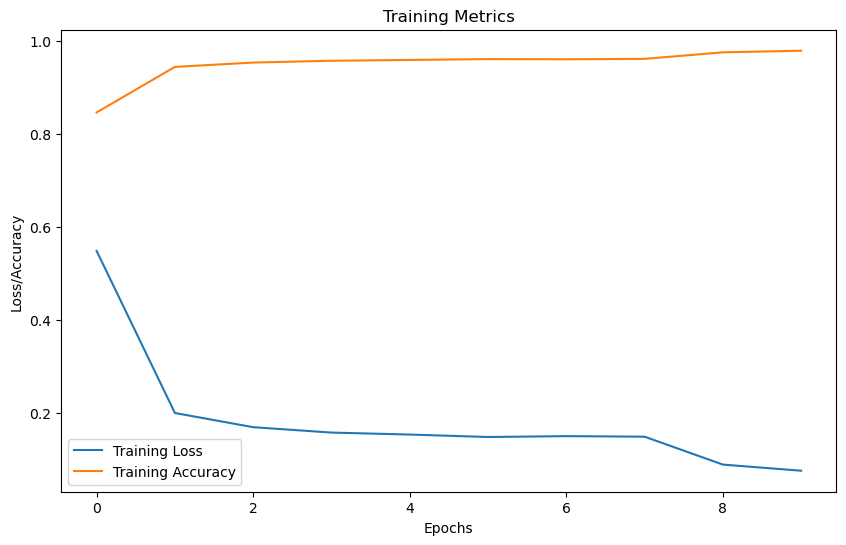

In [16]:
# ## 7. Test the Model

test_score = model.evaluate(X_test, y_test, verbose=0)

print(f"Accuracy for test images: {test_score[1]*100:.2f}%")

# Plot training metrics
plt.figure(figsize=(10, 6))
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["accuracy"], label="Training Accuracy")
plt.title("Training Metrics")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


558/558 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step


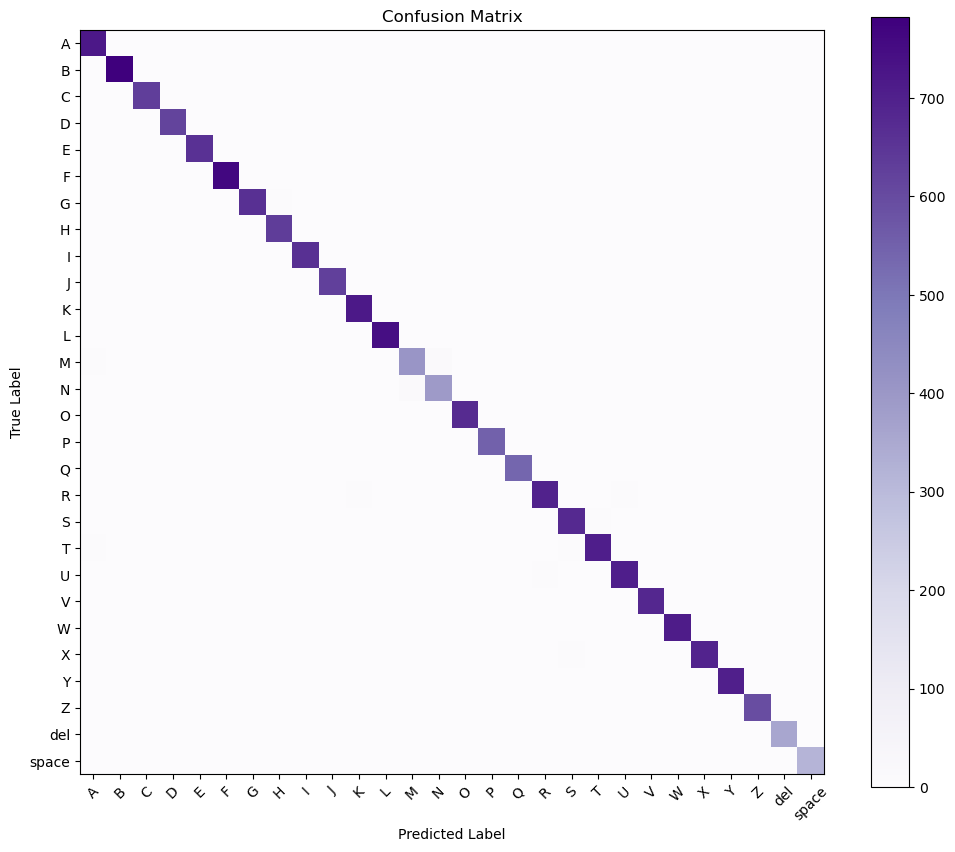

In [17]:
# ## 8. Confusion Matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, cmap="Purples")
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

y_test_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_test_pred, uniq_labels)

In [28]:
# ## 9. Prediction Example

from keras.preprocessing import image

class_names=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X",
             "Y","Z","del","nothing","space"]
sample_image = r"E:\asl_alphabet_train_processed\asl_alphabet_train_processed\M\M (110).jpg"
img = image.load_img(sample_image, target_size=(64, 64))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

predicted_class = np.argmax(model.predict(x))
print(f"Predicted Class: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: N


In [29]:
# Save the model in .h5 format
model.save("asl_cnn_model_preprocessed.h5")
print("Model saved as 'asl_cnn_model_preprocessed.h5'")

Model saved as 'asl_cnn_model_preprocessed.h5'


In [50]:
# Save the model in SavedModel format
model.save("asl_cnn_model_tf", save_format="tf")
print("Model saved in TensorFlow SavedModel format at 'asl_cnn_model_tf/'")

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [30]:
# Save the model in the .keras format
model.save("asl_cnn_model_preprocessed.keras")
print("Model saved as 'asl_cnn_model_preprocessed.keras'")

Model saved as 'asl_cnn_model_preprocessed.keras'


KeyError: 'val_accuracy'

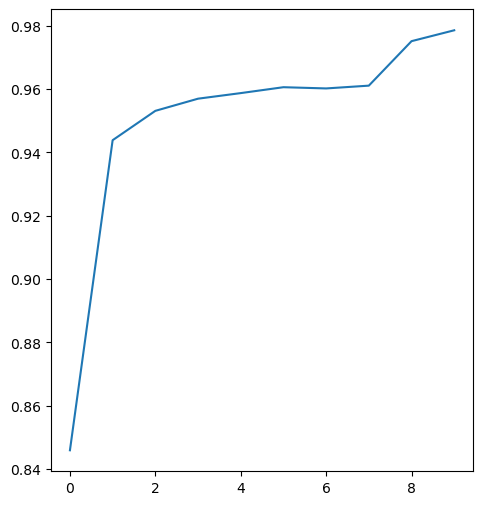

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()
